# PESTPP-GLM

In this notebook, we will run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
t_d = "template"
m_d = "master_glm"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_ss8,cn_ss8,log,1,0,1,-1,0.5
gr_strt3,gr_strt3,log,705,0,0.0211893,-0.0222764,0.0108664
strk,strk,log,40,0,2,-2,1
cn_prsity6,cn_prsity6,log,1,0,0,-1,0.25
cn_vka8,cn_vka8,log,1,0,1,-1,0.5
pp_vka2,pp_vka2,log,32,0,1,-1,0.5
gr_sy4,gr_sy4,log,705,0,0.243038,-0.60206,0.211275
cn_strt6,cn_strt6,log,1,0,0.0211893,-0.0222764,0.0108664
gr_ss3,gr_ss3,log,705,0,1,-1,0.5
gr_prsity5,gr_prsity5,log,705,0,0,-1,0.25


### reduce the number of adjustable parameters

This is the painful part: we cant use 10K+ pars because we cant wait around for that many runs and then the linear algebra of factoring a 10k+ by 10K+ matrix is also difficult.  So that means we need to fix a lot a parameters #frownyface

In [4]:
par = pst.parameter_data

In [5]:
# grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [6]:
# these are the sfr conductance parameters - Ive left all 40 adjustable
# but if you uncomment this, it will tie them into 1 parameter effectively
# strk_pars = par.loc[par.pargp=="strk","parnme"]
# p1 = strk_pars.iloc[0]
# par.loc[strk_pars.iloc[1:],"partrans"] = "tied"
# par.loc[strk_pars.iloc[1:],"partied"] = p1
pst.npar_adj

719

In [7]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_prsity0', 'pp_prsity1',
       'pp_prsity2', 'pp_rech0', 'pp_rech1', 'pp_ss0', 'pp_ss1', 'pp_ss2',
       'pp_strt0', 'pp_strt1', 'pp_strt2', 'pp_sy0', 'pp_sy1', 'pp_sy2',
       'pp_vka0', 'pp_vka1', 'pp_vka2'], dtype=object)

Fix the storage pilot points - we still have layer-scale storage pars adjustable

In [8]:
#s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
#par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [9]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

cn_ss8          1
cn_vka8         1
cn_sy6          1
cn_prsity6      1
cn_sy8          1
cn_ss6          1
cn_rech5        1
cn_strt8        1
cn_strt6        1
cn_strt7        1
cn_hk8          1
cn_sy7          1
cn_prsity8      1
cn_prsity7      1
cn_hk6          1
cn_vka7         1
cn_ss7          1
flow            1
cn_hk7          1
cn_rech4        1
cn_vka6         1
welflux         2
welflux_k02     6
drncond_k00    10
pp_strt2       32
pp_vka0        32
pp_prsity1     32
pp_strt0       32
pp_vka1        32
pp_hk0         32
pp_prsity2     32
pp_hk1         32
pp_ss2         32
pp_sy1         32
pp_hk2         32
pp_rech1       32
pp_ss1         32
pp_sy2         32
pp_ss0         32
pp_sy0         32
pp_strt1       32
pp_rech0       32
pp_prsity0     32
pp_vka2        32
strk           40
Name: pargp, dtype: int64

fix the future recharge pilot points, vka in layers 1 and 3 and the initial condition pilot points (we still have layer-scale pars for each of these types)

In [10]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2","pp_strt0","pp_strt1","pp_strt2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"
pst.npar_adj

527

Ok, thats better...so lets run PESTPP-GLM.  We will use a single "base parameter" jacobian matrix as the basis for 6 super parameter iterations.  Then we will draw 100 realizations from the FOSM posterior parameter covariance matrix and run those 100 realizations to get the psoterior forecast PDFs

In [11]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["num_reals"] = 50 # this is how many ies uses
pst.pestpp_options["parcov"] = "prior_cov.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [12]:
#pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
#                           master_dir=m_d)

In [13]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
37    1523.895945
48    2042.032188
19    2143.616110
9     2699.436467
36    2950.969864
47    2993.890569
23    3009.566777
22    3012.620246
17    3093.354239
5     3262.937353
4     3676.986014
8     3776.487010
26    3796.941236
16    3865.035428
35    4163.396162
12    4220.252488
7     4337.686354
0     4364.978002
1     4607.220793
38    4622.993771
dtype: float64

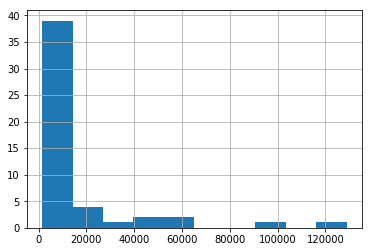

In [14]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [15]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [16]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-682.3380,252.978000,-1188.2900,-176.3830
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-227.9100,342.479000,-912.8690,457.0490
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-138.5270,179.850000,-498.2270,221.1720
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,264.8790,272.352000,-279.8240,809.5820
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,38.8495,0.409407,38.0307,39.6683
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,37.7571,0.749881,36.2573,39.2568
part_status,2.0000,0.00000,2.0000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,704.75100,-501.8010,2317.2000,1059.5000,604.211000,-148.9210,2267.9200


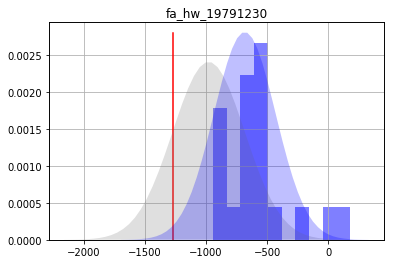

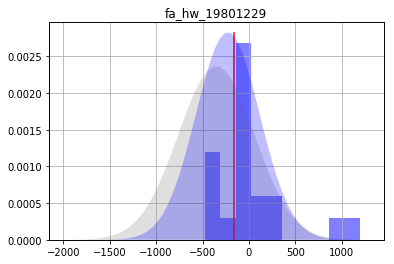

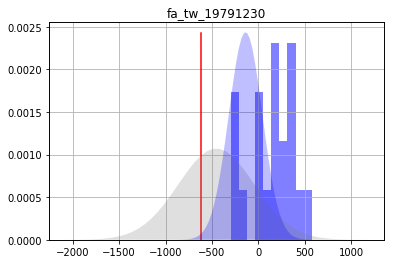

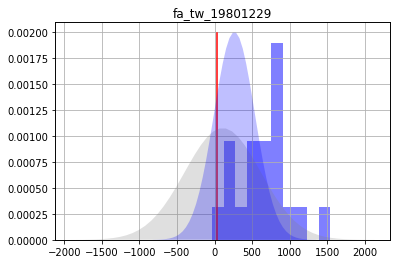

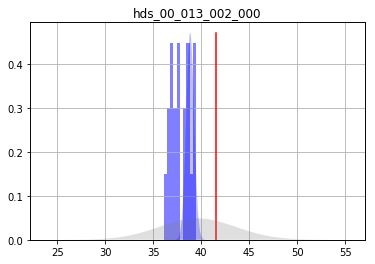

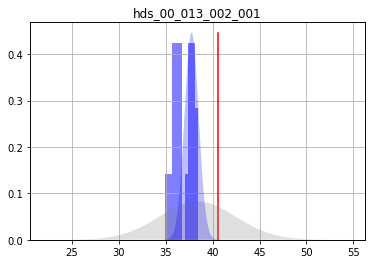

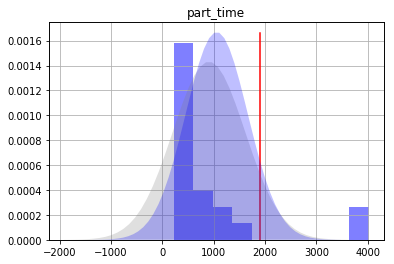

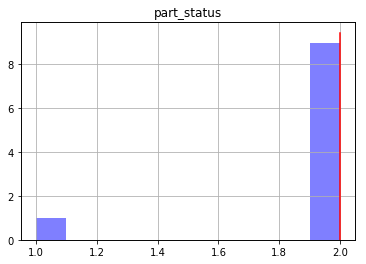

In [17]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [18]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))

new binary format detected...


In [19]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [20]:
pst.prior_information.head()

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_1,1.0 * log(dc0000390005) - 1.0 * log(dc0000390006) = 0.0,regul_cc,pcc_1,0.904837
pcc_2,1.0 * log(dc0000390005) - 1.0 * log(dc0000390007) = 0.0,regul_cc,pcc_2,0.818731
pcc_3,1.0 * log(dc0000390005) - 1.0 * log(dc0000390008) = 0.0,regul_cc,pcc_3,0.740818
pcc_4,1.0 * log(dc0000390005) - 1.0 * log(dc0000390009) = 0.0,regul_cc,pcc_4,0.670320
pcc_5,1.0 * log(dc0000390005) - 1.0 * log(dc0000390010) = 0.0,regul_cc,pcc_5,0.606531


In [21]:
shutil.copy2(os.path.join(m_d,"freyberg_pp.jcb"),os.path.join(t_d,"restart_pp.jcb"))


'template/restart_pp.jcb'

In [22]:
pst.pestpp_options["base_jacobian"] = "restart_pp.jcb"
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [23]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [24]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
44     130.579259
5      321.563856
26     381.157171
9      577.767558
49     618.944141
33     855.257008
19     878.785248
36    1051.302904
23    1093.226820
45    1106.638514
16    1288.516487
1     1568.062185
39    1611.842103
8     1690.778055
11    1703.743351
17    1770.921239
27    1809.781426
38    2176.745162
47    2432.286487
0     2468.998917
dtype: float64

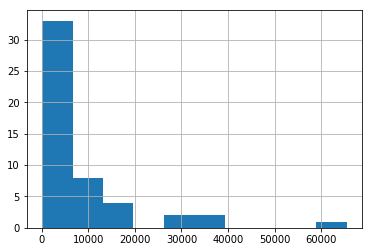

In [25]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [26]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [27]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-1227.3700,260.787000,-1748.9400,-705.7950
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-379.8370,354.292000,-1088.4200,328.7470
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-889.7540,184.343000,-1258.4400,-521.0690
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,-168.2100,278.838000,-725.8860,389.4660
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,41.5028,0.304894,40.8930,42.1126
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,40.0225,0.701360,38.6197,41.4252
part_status,2.0000,0.00000,2.0000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,704.75100,-501.8010,2317.2000,1703.2000,608.564000,486.0740,2920.3300


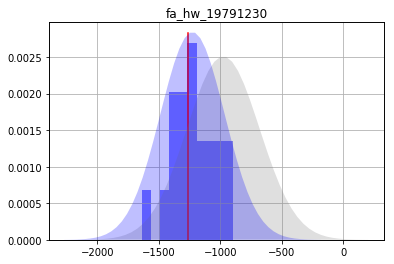

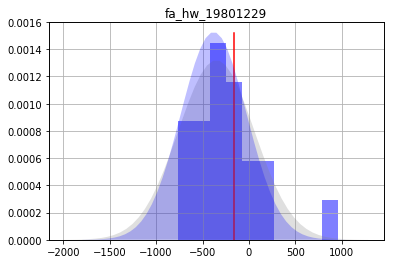

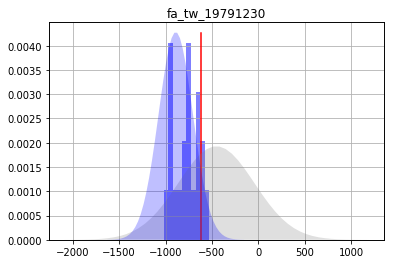

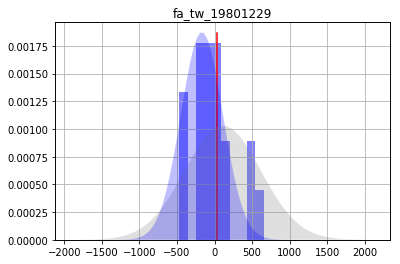

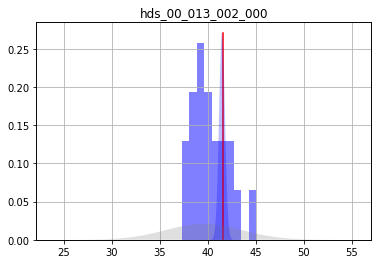

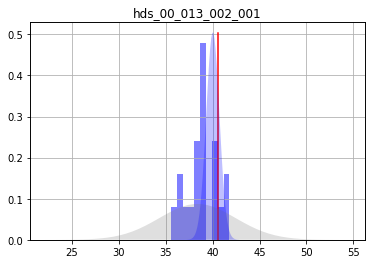

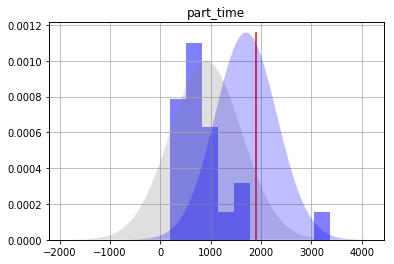

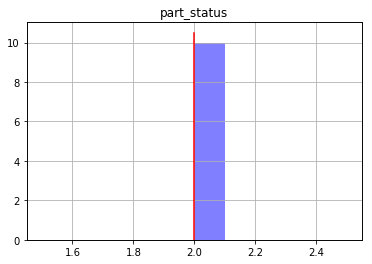

In [28]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()